# Improved LSTM baseline

This kernel is a somewhat improved version of [Keras - Bidirectional LSTM baseline](https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-051) along with some additional documentation of the steps.

In [39]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

We include the GloVe word vectors in our input files. To include these in your kernel, simple click 'input files' at the top of the notebook, and search 'glove' in the 'datasets' section.

In [40]:
EMBEDDING_FILE='word_vectors/shuf_wiki_youtube_toxic_dim100_epoch5.txt'
TRAIN_DATA_FILE='input/train.csv'
TEST_DATA_FILE='input/test.csv'

Set some basic config parameters:

In [41]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 300 # max number of words in a comment to use
# consider increase to 200 to 300 

Read in our data and replace missing values:

In [42]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)
# fasttext preprocessing
train[COMMENT] = train[COMMENT].str.lower().str.replace('https?:\/\/[^\s]*','').str.replace("’","'").str.replace("''",' ').str.replace("'"," ' ").str.replace('“','"').str.replace('”','"').str.replace(':',' : ').str.replace('.',' . ').str.replace(',',' , ').str.replace('[',' [ ').str.replace(']',' ] ').str.replace('(',' ( ').str.replace(')',' ) ').str.replace('!',' ! ').str.replace('?',' ? ').str.replace(';',' ').str.replace(':',' ').str.replace('-',' - ').str.replace('=', ' ').str.replace('=', ' ').str.replace('*', ' ').str.replace('|', ' ').str.replace('«', ' ').str.replace('\d', ' ').str.replace('\n', ' ').str.replace('\s\s+',' ').str.replace('\n','NEWLINE ').str.strip().str.replace("[^\s\d\w)(;:\-+_?!\]\[,*,'\"]+","")
test[COMMENT] = test[COMMENT].str.lower().str.replace('https?:\/\/[^\s]*','').str.replace("’","'").str.replace("''",' ').str.replace("'"," ' ").str.replace('“','"').str.replace('”','"').str.replace(':',' : ').str.replace('.',' . ').str.replace(',',' , ').str.replace('[',' [ ').str.replace(']',' ] ').str.replace('(',' ( ').str.replace(')',' ) ').str.replace('!',' ! ').str.replace('?',' ? ').str.replace(';',' ').str.replace(':',' ').str.replace('-',' - ').str.replace('=', ' ').str.replace('=', ' ').str.replace('*', ' ').str.replace('|', ' ').str.replace('«', ' ').str.replace('\d', ' ').str.replace('\n', ' ').str.replace('\s\s+',' ').str.replace('\n','NEWLINE ').str.strip().str.replace("[^\s\d\w)(;:\-+_?!\]\[,*,'\"]+","")

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [43]:
# TODO test average, max, min comments words
test_train = train.copy()
test_train['tokens'] = test_train[COMMENT].str.split()

In [44]:
test_train['tokens_len'] = test_train['tokens'].apply(lambda x: len(x))

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
print('mean:',test_train['tokens_len'].mean(), 'min:',test_train['tokens_len'].min(), 'max:',test_train['tokens_len'].max())

mean: 75.3940377638 min: 0 max: 4948


In [46]:
test_train['tokens_len'].sample(n=3000).mean()

75.115666666666669

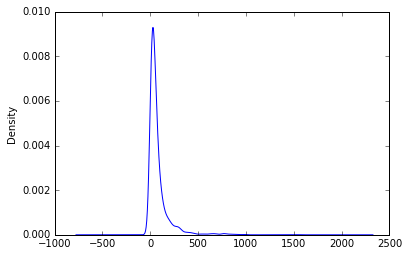

In [47]:
test_train['tokens_len'].sample(n=3000).plot(kind='density')

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [48]:
# tokenizer = Tokenizer(num_words=max_features)
# TODO filters=''
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the wiki user comments word vectors (space delimited strings) into a dictionary from word->vector.

In [49]:
dim = 100
def get_coefs(*tokens):     
    tokens_len = len(tokens)
    word = ''.join(tokens[:tokens_len-dim])
    vector = tokens[tokens_len-dim:]
    return word,np.asarray(vector, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [50]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.0069545256, 0.33197695)

In [51]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [55]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Conv1D(32,kernel_size=3,padding='same',activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)
x = Conv1D(64,kernel_size=3,padding='same',activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Dropout(0.1)(x)
#x = Flatten()(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [53]:
history = model.fit(X_t, y, batch_size=32, epochs=2, validation_split = 0.3);
model.save("toxic.h5")

Train on 111699 samples, validate on 47872 samples
Epoch 1/2
111699/111699 [==============================] - 886s - loss: 0.0601 - acc: 0.9793 - val_loss: 0.0529 - val_acc: 0.9799
Epoch 2/2
111699/111699 [==============================] - 1173s - loss: 0.0457 - acc: 0.9828 - val_loss: 0.0576 - val_acc: 0.9779


In [56]:
model.fit(X_t, y, batch_size=32, epochs=1);
model.save("toxic.h5")

Epoch 1/1
159571/159571 [==============================] - 1390s - loss: 0.0586 - acc: 0.9797  


And finally, get predictions for the test set and prepare a submission CSV:

dict_keys(['acc', 'val_acc', 'loss', 'val_loss'])


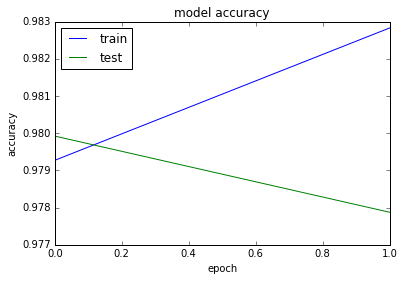

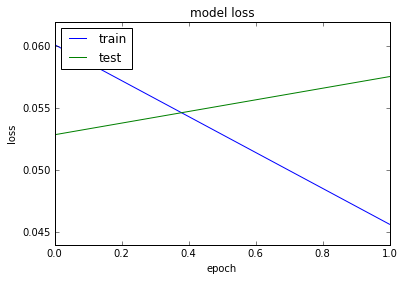

In [54]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

153164/153164 [==============================] - 307s   


In [58]:
sample_submission = pd.read_csv('input/sample_submission.csv')

In [59]:
sample_submission[list_classes] = y_test
sample_submission.to_csv('cnn_lstm_submission.csv', index=False)